In [1]:
%load_ext autoreload
%autoreload 2

from model.autoregressive import ARModel
from model import LinearModel
from filtering.colkf import ColKF
from filtering.enkf import EnKF
from utils.plotter import Plotter

import numpy as np

In [2]:
A = lambda _: np.diag([0.9, 0.9])
initial_condition = np.array([0.5, 0.5])
system_cov = lambda _: 1 * np.eye(2)
generator = np.random.default_rng(12345)
H = lambda _: np.zeros((0, initial_condition.shape[0]))

init_time = 0
time_step = 0.1
end_time = 30

ar_model = ARModel(A, H, initial_condition, time_step, system_cov, generator)

In [3]:
init_state = np.array([np.pi / 2, 0.5])
init_state_cov = 0.5 * np.eye(len(init_state))
n_states = len(init_state)
n_obs = 2
M = lambda _: np.array([[0, 1], [-1, 0]])
M = lambda _: np.array([[0, 1], [-2, -0.5]])
H = lambda _: np.eye(n_obs)
system_cov = lambda _: 0.05 * np.eye(n_states)
obs_cov = lambda _: 0.01 * np.eye(n_obs)

In [4]:
linear_model = LinearModel(
    init_state, time_step, M, H, system_cov, obs_cov, generator, solver="rk4"
)
times, states = linear_model.integrate(init_time, end_time)

# Generate observations with noise
assimilation_times = np.arange(1, end_time, 1)
observed = np.zeros((n_obs, len(assimilation_times)))
observed_true = np.zeros((n_obs, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = linear_model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = linear_model.observe(states[:, k])

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 26.71it/s]


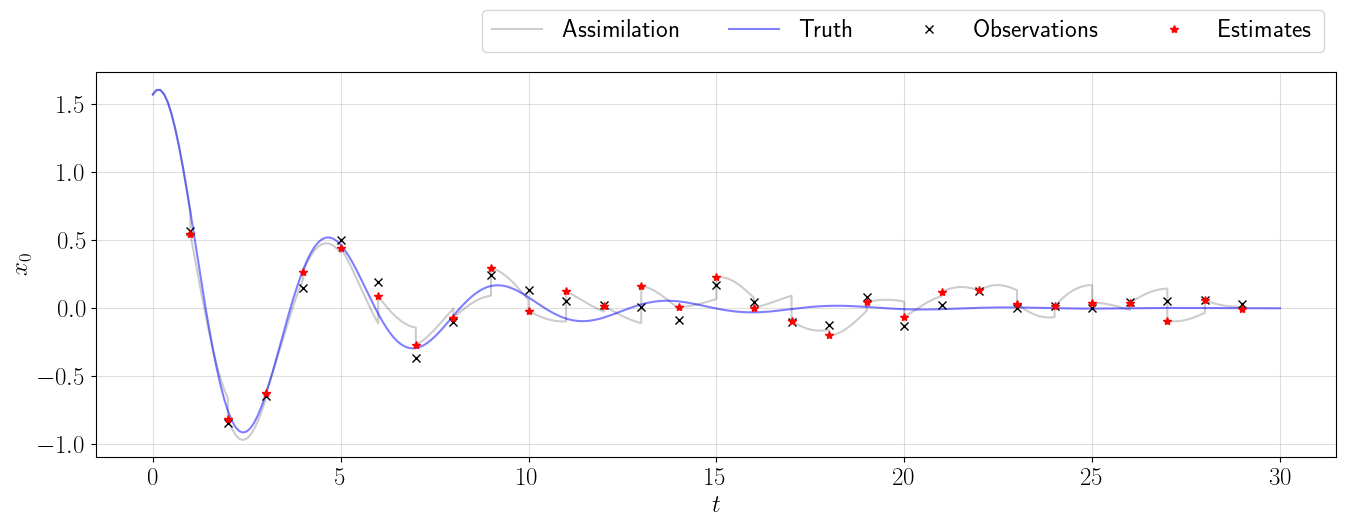

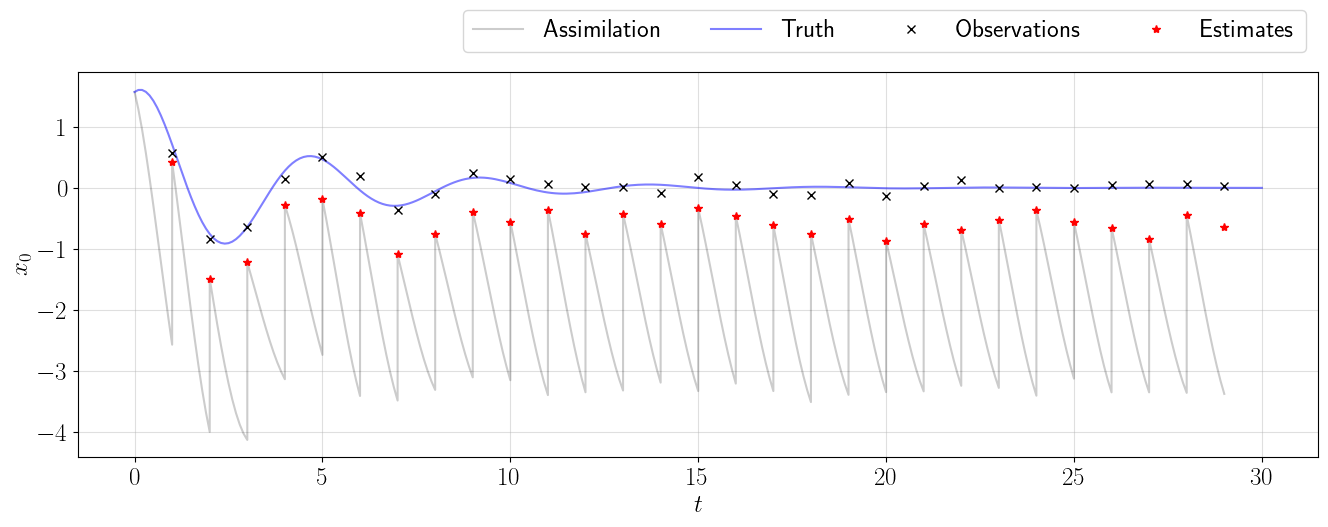

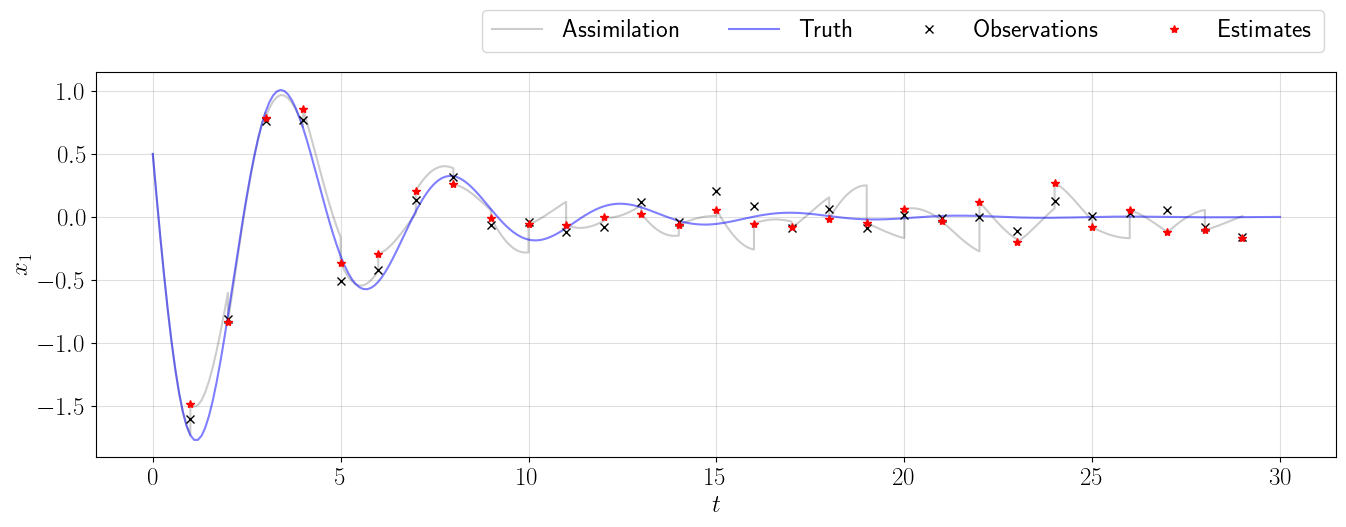

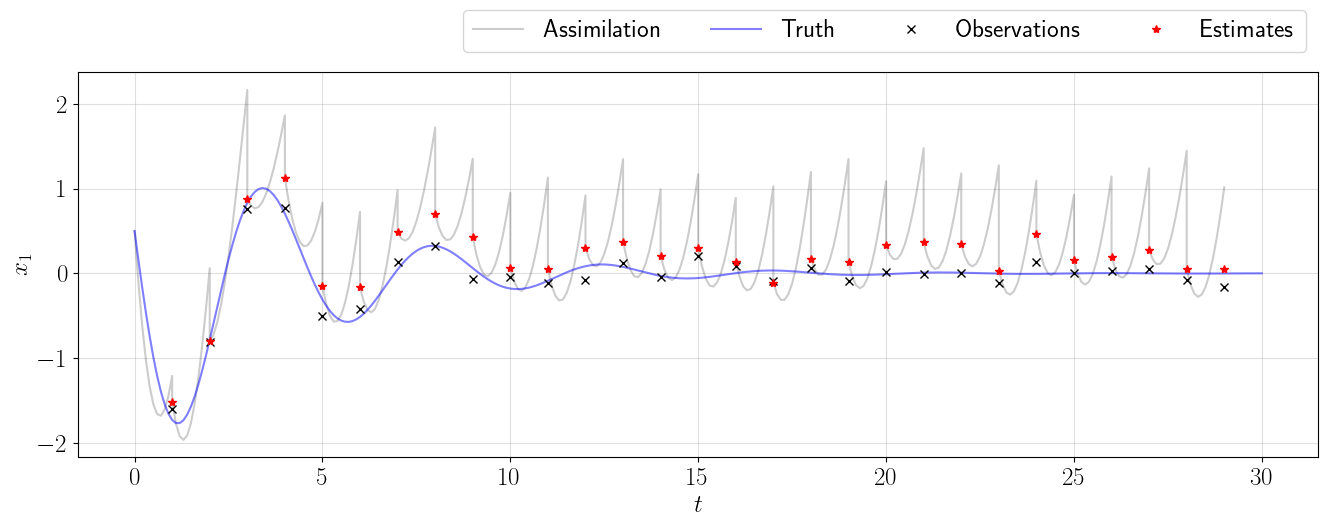

In [5]:
linear_model.offset = lambda *_: -3 * np.ones_like(init_state)
linear_model.reset_model()

ensemble_size = 40
assimilation_data = observed
cut_off_time = None
# Run EnKF
enkf = EnKF(linear_model, init_state, init_state_cov, ensemble_size)
results_enkf = enkf.filter(
    assimilation_times, observed, cut_off_time=cut_off_time, run_id="bias"
)
results_enkf.true_times = times
results_enkf.true_states = states

# Run ColKF
init_bias = np.array([0, 0])
init_bias_cov = 0.4 * np.eye(2)
feedback = True

ar_model.reset_model()
enkf.model.reset_model()
colkf = ColKF(
    ar_model, enkf, init_state, init_state_cov, init_bias, init_bias_cov, feedback
)
results_colkf = colkf.filter(
    assimilation_times, observed, cut_off_time=cut_off_time, run_id="bias"
)
results_colkf.true_times = times
results_colkf.true_states = states

sample = [0, 1]
window = 15
for state_idx in sample:
    results_colkf.plot_filtering(
        state_idx,
        path=f"colkf_{state_idx}.pdf",
    )
    results_enkf.plot_filtering(
        state_idx,
        path=f"enkf_{state_idx}.pdf",
    )

    # ax = results_enkf.plot_innovations(state_idx, window=window)
    # results_colkf.plot_innovations(
    #     state_idx,
    #     path=f"innovations_{state_idx}.pdf",
    #     ax=ax,
    #     window=window,
    #     linestyle="--",
    # )
# plt.show()

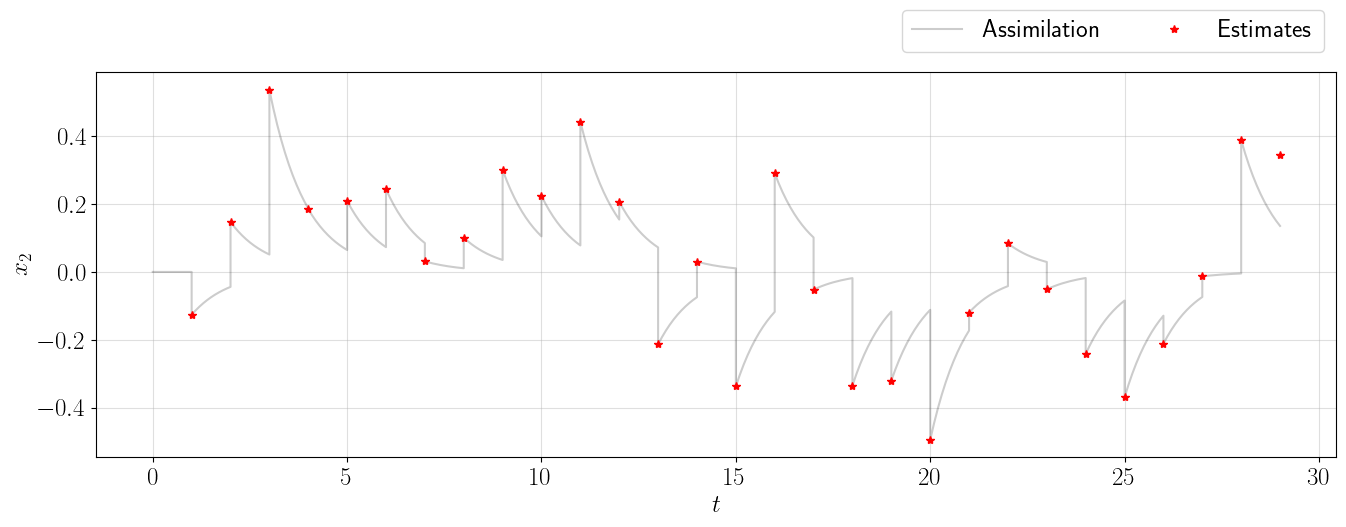

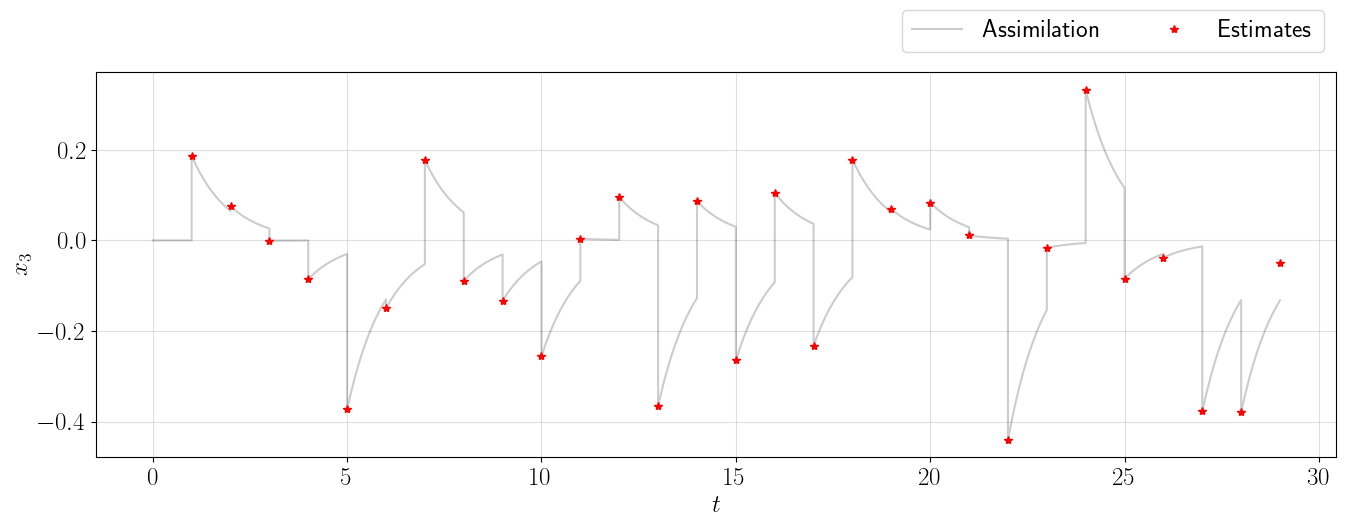

In [6]:
sample = [2, 3]
for state_idx in sample:
    results_colkf.plot_filtering(
        state_idx, path=f"colkf_{state_idx}.pdf", only_state=True
    )